In [1]:
import numpy as np
import pyjags
import pandas as pd
import matplotlib.pyplot as plt
import corner
%matplotlib notebook

In [2]:
#To read the files, if needed
def readCODA(findex,fchain):
    names=np.loadtxt(findex, usecols=[0], dtype=str,ndmin=1)
    print names.shape
    
    names=np.array(names)
    try:
        n_vars=len(names)
    except:
        n_vars=1
    raw_table=np.loadtxt(fchain,usecols=[1])
    #print raw_table.shape
    table=raw_table.reshape([-1,n_vars],order='F')
    #print table.shape
    df = pd.DataFrame(table, columns=names)
    return df
    #names,i_start,i_stop = np.loadtxt(findex, unpack=True,format="")
  
#pyjags returns a dictionary, we translate it to Pandas
def from_dict2pd(sample, nchain=-1):
    new_dict=dict()
    for key in sample:
        aa=sample[key]
        aa_shape=aa.shape
        #First dimension is the dimension of the array of samples
        #Second dimension is the length of the chain
        # Third dimension is the number of chains
        if nchain >= aa_shape[2]:
            print "Error You asked the chain larger than your number of chains"
            return
        
        
        for i in range(aa_shape[0]):
            if aa_shape[0] > 1:
                print "Variable %s is an array of dimension %d"%(key,aa_shape[0])
                new_key="%s_%02d"%(key,i)
            else:
                new_key=key
                
            if nchain == -1:
                bb=aa[i,:,:].flatten()
            else:
                try:
                    bb=aa[i,:,nchain]
                except:
                    print "Index out of limit"
                    return
                
            new_dict[new_key]=bb
            print "Added key "+new_key
        
            
        
    sample_pd=pd.DataFrame.from_dict(new_dict)
    return sample_pd

In [3]:
#Make contour plots using corner
def contour_plot(x, y):
    fig, axes = plt.subplots(1, 1)
    #corner.hist2d(x.values, y.values, levels=[0.682689492, 0.954499736], \
    #              plot_datapoints=False, plot_density=False, ax=axes, color='blue')
    corner.hist2d(x.values, y.values, levels=[0.682689492, 0.954499736], \
                  plot_datapoints=False, plot_density=True, ax=axes, color='blue')
    
    axes.set_xlabel(x.name);
    axes.set_ylabel(y.name);

In [4]:
#set up
n_chains=3
used_chain=2

In [24]:
#Read data from file Using Pandas
input_data=pd.read_csv("data_mogorrian.txt", dtype=float)
#Test the conversion to dictionary
print input_data.to_dict('list').keys()

['erry', 'errx', 'obsx', 'obsy']


In [25]:
print input_data['obsx'].mean()
print input_data['obsy'].mean()


2.26192967742
7.97055032258


In [27]:
#PyJags run

#Code
code = '''
model {
    for (i in 1:length(obsx))
    {
        obsy[i] ~ dnorm(y[i], pow(erry[i],-2))
        obsx[i] ~ dnorm(x[i], pow(errx[i],-2))
        x[i] ~ dunif(-1e-4,1e4)
        y[i] ~ dnorm( A + B * (x[i] - 2.3), prec )
    }

    A ~ dnorm(0,1e-6)
    B ~ dt(0,1,1)
    prec ~ dgamma(1e-2,1e-2)
    sigma <- 1/sqrt(prec)
    
}
'''

#B is distributed as Student-T distribution with one degree of fredom, this is uniform in the angle

model = pyjags.Model(code, data=input_data.to_dict('list'),
                     chains=n_chains,generate_data=True, adapt=3000) 
# equivalent in data file to obsn <- c (8,4,3,5) Use c to indicate it is a struture !!

#Update
model.update(3000)

#Makes the runs
samples = model.sample(100000, vars=['A','B','sigma'], thin=10)


adapting: iterations 9000 of 9000, elapsed 0:00:01, remaining 0:00:00
updating: iterations 9000 of 9000, elapsed 0:00:00, remaining 0:00:00
sampling: iterations 163119 of 300000, elapsed 0:00:08, remaining 0:00:06
sampling: iterations 268728 of 300000, elapsed 0:00:13, remaining 0:00:02
sampling: iterations 300000 of 300000, elapsed 0:00:15, remaining 0:00:00


In [28]:
#Translate the output dictionary to Pandas
samples_pd=from_dict2pd(samples,used_chain)

Added key A
Added key B
Added key sigma


In [29]:
#Show the parameters
for kk in samples_pd.keys():
    print samples_pd[kk].describe()
    print " "


count    10000.000000
mean         8.131573
std          0.063030
min          7.839008
25%          8.090628
50%          8.131852
75%          8.173549
max          8.391877
Name: A, dtype: float64
 
count    10000.000000
mean         3.900610
std          0.323816
min          2.694802
25%          3.689814
50%          3.896164
75%          4.113191
max          5.265689
Name: B, dtype: float64
 
count    10000.000000
mean         0.280873
std          0.055141
min          0.132411
25%          0.241924
50%          0.274719
75%          0.313772
max          0.564732
Name: sigma, dtype: float64
 


<IPython.core.display.Javascript object>


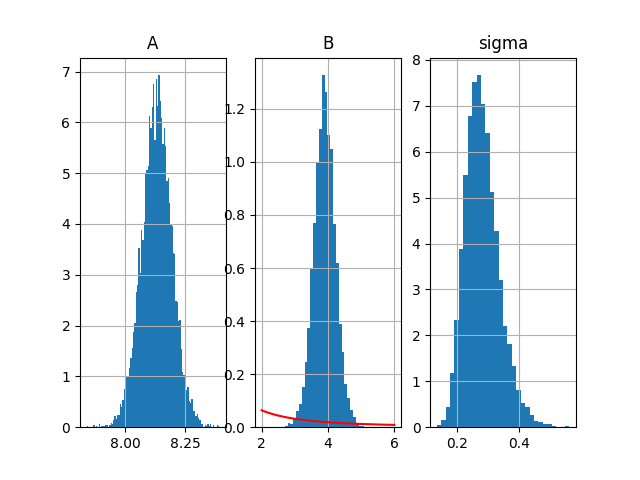

(array([49]),)
[-0.00010101] [ 0.01010101] [ nan]
The ratio of likelihoods is the ODD factor nan
The log of ODD factor is nan


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 99 but corresponding boolean dimension is 100
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 99 but corresponding boolean dimension is 100
  del sys.path[0]


Text(0.5,1,u'sigma')

In [31]:
from scipy.stats import t as stud_t

# Just Histograms
plt.figure()
plt.subplot(1,3,1)
ax1=samples_pd['A'].hist(bins=100, normed=True, label="A")
bins=np.linspace(-.5,0.51,100)
hh,xh = np.histogram(samples_pd['A'].values, bins=bins, normed=True)
ind = np.abs(xh)<0.001
print np.nonzero(ind)
print xh[ind],xh[np.roll(ind,1)], hh[ind]

ratio=hh[ind] /stud_t.pdf((xh[ind]+xh[np.roll(ind,1)])/2,1)

print "The ratio of likelihoods is the ODD factor %.1f"%(ratio)
print "The log of ODD factor is %.1f"%(np.log10(ratio))

ax1.set_title("A")
plt.subplot(1,3,2)
ax2=samples_pd['B'].hist(bins=30, normed=True, label="B")
ax2.set_title("B")

xx = np.linspace(2,6,100)


yy=stud_t.pdf(xx, 1)
#print yy
plt.plot(xx,yy,color='red')
#ax2.set_ylim([0,10])

plt.subplot(1,3,3)
ax3=samples_pd['sigma'].hist(bins=30, normed=True, label="sigma")
ax3.set_title("sigma")


<IPython.core.display.Javascript object>


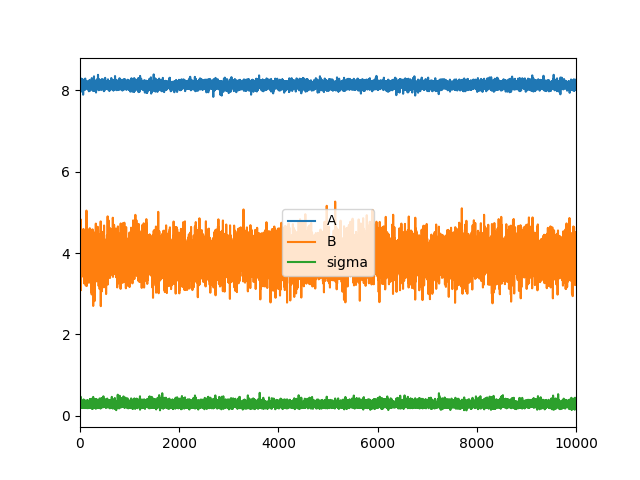

In [32]:
#Traces
samples_pd.plot()

<IPython.core.display.Javascript object>


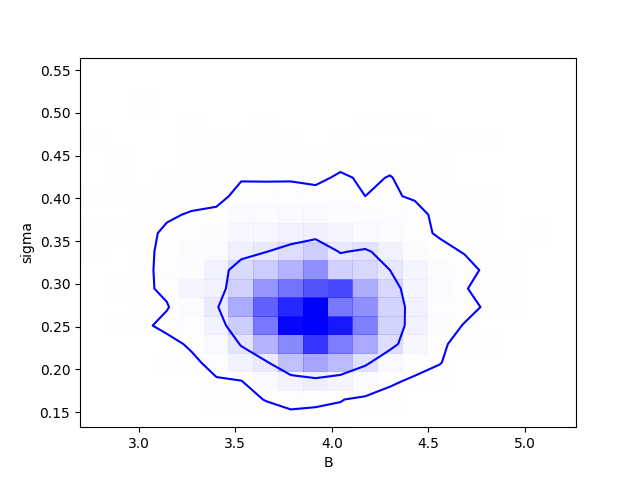

In [33]:
#Plot one contour
contour_plot(x=samples_pd['B'], y=samples_pd['sigma'])


<IPython.core.display.Javascript object>


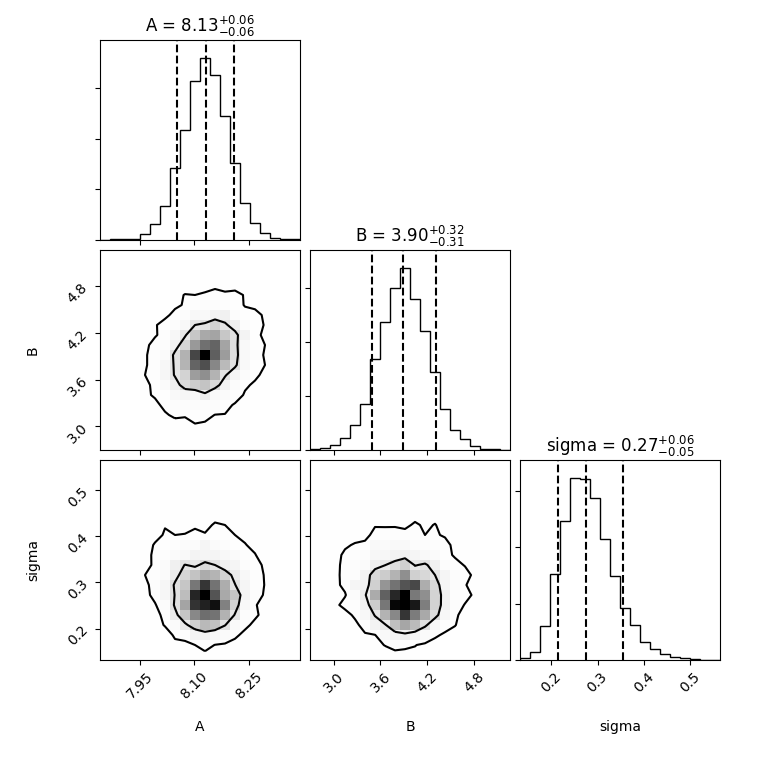

In [34]:
#Make the corner plot
def corner_from_pd(samples_pd):
    n_var=len(samples_pd.keys())
    n_sample=len(samples_pd.index)
    
    data=np.zeros([n_sample,n_var])
    for i, kk in enumerate(samples_pd.keys()):
        data[:,i]=samples_pd[kk].values
    corner.corner(data, labels=samples_pd.keys(),
                        quantiles=[0.1, 0.5, 0.9],
                        show_titles=True,levels=[0.682689492, 0.954499736],
                        plot_datapoints=False, )
corner_from_pd(samples_pd)

<IPython.core.display.Javascript object>


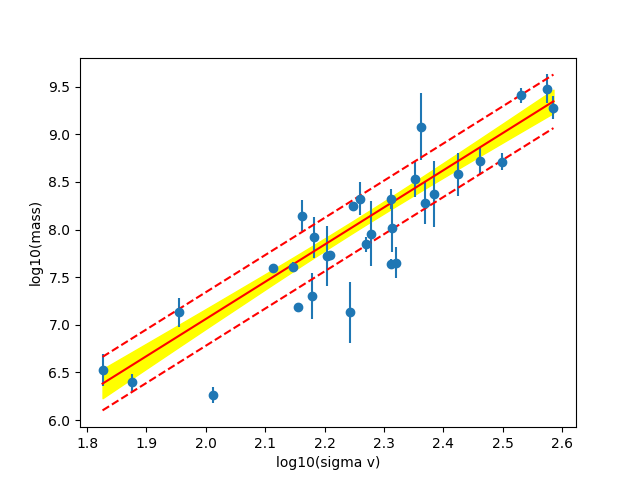

{u'A': 8.1315730492113367, u'B': 3.9006104882110573, u'sigma': 0.28087280848034979}
{u'A': 8.4124458576916865, u'B': 3.9006104882110573, u'sigma': 0.28087280848034979}


In [37]:
#Write the model using python 
from scipy.special import erf

def efficiency(x, params):
    A=params['A']
    B=params['B']
    sigma=params['sigma']
    return 0.1+A + B*(x-2.3)


#Plots the Data
plt.figure()
x=input_data['obsx'].values
ind = x.argsort()
y=input_data['obsy'].values
#Expected error on binomial distribution
#https://stats.stackexchange.com/questions/29641/standard-error-for-the-mean-of-a-sample-of-binomial-random-variables
dy=input_data['erry']

x=x[ind]
y=y[ind]
dy=dy[ind]

ax1=plt.errorbar(x,y,yerr=dy, capsize=0, fmt='o')
plt.xlabel('log10(sigma v)')
plt.ylabel('log10(mass)')

#Define a dictionary with parameters
best_params=dict.fromkeys(samples.keys())
for kk in samples.keys():
    best_params[kk]=samples_pd[kk].values.mean()

#Plots the regression
y_model = efficiency(x,best_params)
plt.plot(x,y_model, color='red')

#Computes the confidence interval
n_samples=len(samples_pd.index)
n_x=len(x)

tmp_array=np.zeros([n_samples,n_x])
params=dict.fromkeys(samples.keys())
#print tmp_array.shape
for i in range(n_samples):
    for kk in samples.keys():
        params[kk]=samples_pd[kk].values[i]
        #print params[kk]    
    tmp_array[i,:]=efficiency(x,params)

#Here we use the standard deviation as a proxy of the 68% percentile
error = tmp_array.std(axis=0)
ax2=plt.fill_between(x, efficiency(x,best_params)-error, efficiency(x,best_params)+error, color='yellow')

print best_params
# plots 1-sigma of instrinsic scatter
best_params['A']=best_params['A']+samples_pd['sigma'].values.mean()
y_model = efficiency(x,best_params)
plt.plot(x,y_model, color='red', linestyle='--')
print best_params

best_params['A']=best_params['A']-2*samples_pd['sigma'].values.mean()
y_model = efficiency(x,best_params)
plt.plot(x,y_model, color='red', linestyle='--')
